# This notebook plots the average number of robust MCS comparisons for a set of regions 

## It uses MCS track statistics file and counts each unique MCS located on a 1x1 degree grid once

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from itertools import chain
import copy
%matplotlib inline

In [2]:
# Dictionary for official model names
model_name = {
    'obs': 'OBS',
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

lifetime_bounds = [2,400]
sdate = '2020-02-01T00'
edate = '2020-03-01T00'

# test = ''
test = '_pf0duration'
rootdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/'
obsdir = f'{rootdir}obs/stats{test}/'
obsfile = f'{obsdir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'

name_map = {
    'obs': 'obs',
    'm1': 'mpi',
    'm2': 'scream',
    'm3': 'nasa',
    'm4': 'nicam',
    'm5': 'noaa',
    'm6': 'uk',
}
m1dir = f'{rootdir}{name_map["m1"]}/stats{test}/'
m2dir = f'{rootdir}{name_map["m2"]}/stats{test}/'
m3dir = f'{rootdir}{name_map["m3"]}/stats{test}/'
m4dir = f'{rootdir}{name_map["m4"]}/stats{test}/'
m5dir = f'{rootdir}{name_map["m5"]}/stats{test}/'
m6dir = f'{rootdir}{name_map["m6"]}/stats{test}/'
m1file = f'{m1dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m2file = f'{m2dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m3file = f'{m3dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m4file = f'{m4dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m5file = f'{m5dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'
m6file = f'{m6dir}mcs_tracks_robust_20200120.0000_20200301.0000.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures_pf0duration/


In [3]:
obsfile, m1file, m2file, m3file, m4file, m5file, m6file

('/global/cfs/cdirs/m1867/zfeng/dyamond-winter/obs/stats_pf0duration/mcs_tracks_robust_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/mpi/stats_pf0duration/mcs_tracks_robust_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/scream/stats_pf0duration/mcs_tracks_robust_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nasa/stats_pf0duration/mcs_tracks_robust_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nicam/stats_pf0duration/mcs_tracks_robust_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/noaa/stats_pf0duration/mcs_tracks_robust_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/uk/stats_pf0duration/mcs_tracks_robust_20200120.0000_20200301.0000.nc')

## Custom functions for track selections

In [4]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track initiation location
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_basetime >= pd.to_datetime(sdate)) & (start_basetime <= pd.to_datetime(edate)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )[0]
    return mcsidx

def get_unique_placements(track_num, lat, lon, ntimes):
    """
    Get unique pairs of lat/lon for a track
    """
    # Put all lat/lon pairs over each time for a track into an array
    this_row = np.array([[lat[track_num, tt], lon[track_num, tt]] for tt in range(0, ntimes)])
    # Return the unique pairs (axis=0)
    return np.array(np.unique(this_row, axis=0))

def count_unique_mcs(lat, lon, xbins, ybins):
    
    ntracks, ntimes = lat.shape

    # A function to loop over tracks
    get_unique = lambda D: get_unique_placements(D, lat, lon, ntimes)

    # Loop over each track and get the unique pairs of lat/lon
    all_uniques = list(map(get_unique, np.arange(0, ntracks)))

    # Flatten the list of lat/lon pairs (using chain), and convert into an array
    unique_latlon = np.array(list(chain(*all_uniques)))

    # Count number on map using histogram2d
    ranges = [[min(ybins), max(ybins)], [min(xbins), max(xbins)]]
    hist2d, yedges, xedges = np.histogram2d(unique_latlon[:,0], unique_latlon[:,1], bins=[ybins, xbins], range=ranges)

    return hist2d

In [5]:
# Read OBS MCS data
dsobs = xr.open_dataset(obsfile)
time_res_obs = dsobs.attrs['time_resolution_hour']
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
dsobs

<xarray.Dataset>
Dimensions:                  (tracks: 3607, times: 200, mergers: 200, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 3603 3604 3605 3606
  * times                    (times) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * mergers                  (mergers) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/50)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_landfrac              (tracks, times) float32 ...
    total_rain               (tracks, times) float32 ...
    total_heavyrain          (tracks, times) float32 ...
    rainrate_heavyrain       (tracks, times) float32 ...
    pf_lifetime              (tracks) float32 ...
    pf_mcsstatus             (tracks, times) float64 ...
Attributes: (12/22)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Mon Dec  5 11:05:07 2022
    startdate:                   20200120.0000
    enddate:                     20200301.0000
    ...                          ...
    MCS_PF_duration_thresh:      4
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [1962    0]
    coefs_pf_rr:                 [2.72873 0.     ]
    coefs_pf_skew:               [0.036384 0.      ]
    coefs_pf_heavyratio:         [0.75026 0.     ]

In [6]:
# Read m1 data
dsm1 = xr.open_dataset(m1file)
time_res_m1 = dsm1.attrs['time_resolution_hour']
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']

In [7]:
# Read m2 data
dsm2 = xr.open_dataset(m2file)
time_res_m2 = dsm2.attrs['time_resolution_hour']
pixel_radius_m2 = dsm2.attrs['pixel_radius_km']

In [8]:
# Read m3 data
dsm3 = xr.open_dataset(m3file)
time_res_m3 = dsm3.attrs['time_resolution_hour']
pixel_radius_m3 = dsm3.attrs['pixel_radius_km']

In [9]:
# Read m4 data
dsm4 = xr.open_dataset(m4file)
time_res_m4 = dsm4.attrs['time_resolution_hour']
pixel_radius_m4 = dsm4.attrs['pixel_radius_km']

In [10]:
# Read m5 data
dsm5 = xr.open_dataset(m5file)
time_res_m5 = dsm5.attrs['time_resolution_hour']
pixel_radius_m5 = dsm5.attrs['pixel_radius_km']

In [11]:
# Read m6 data
dsm6 = xr.open_dataset(m6file)
time_res_m6 = dsm6.attrs['time_resolution_hour']
pixel_radius_m6 = dsm6.attrs['pixel_radius_km']

## Count number of MCSs on grid

In [12]:
# Make 1x1 deg lat/lon bins for couting
ranges = [[-60,60], [0,360]]
xbins = np.arange(0, 360.1, 1)
ybins = np.arange(-60., 60.1, 1)

In [13]:
# Get track initial time valuees
base_time_obs = dsobs.base_time.load()
starttime_obs = base_time_obs.isel(times=0)
# Find track indices within start/end datetime
mcsidx_obs = np.where((starttime_obs >= pd.to_datetime(sdate)) & (starttime_obs <= pd.to_datetime(edate)))[0]
nmcs_obs = len(mcsidx_obs)
print(f'Number of MCS (OBS): {nmcs_obs}')

# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_obs = dsobs.meanlat.isel(tracks=mcsidx_obs).load().round().data
rlon_obs = dsobs.meanlon.isel(tracks=mcsidx_obs).load().round().data

Number of MCS (OBS): 2540


In [14]:
# Get track initial time valuees
base_time_m1 = dsm1.base_time.load()
starttime_m1 = base_time_m1.isel(times=0)
# Find track indices within start/end datetime
mcsidx_m1 = np.where((starttime_m1 >= pd.to_datetime(sdate)) & (starttime_m1 <= pd.to_datetime(edate)))[0]
nmcs_m1 = len(mcsidx_m1)
print(f"Number of MCS ({name_map['m1']}): {nmcs_m1}")

# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_m1 = dsm1.meanlat.isel(tracks=mcsidx_m1).load().round().data
rlon_m1 = dsm1.meanlon.isel(tracks=mcsidx_m1).load().round().data

Number of MCS (mpi): 1157


In [15]:
# Get track initial time valuees
base_time_m2 = dsm2.base_time.load()
starttime_m2 = base_time_m2.isel(times=0)
# Find track indices within start/end datetime
mcsidx_m2 = np.where((starttime_m2 >= pd.to_datetime(sdate)) & (starttime_m2 <= pd.to_datetime(edate)))[0]
nmcs_m2 = len(mcsidx_m2)
print(f"Number of MCS ({name_map['m2']}): {nmcs_m2}")

# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_m2 = dsm2.meanlat.isel(tracks=mcsidx_m2).load().round().data
rlon_m2 = dsm2.meanlon.isel(tracks=mcsidx_m2).load().round().data

Number of MCS (scream): 1825


In [16]:
# Get track initial time valuees
base_time_m3 = dsm3.base_time.load()
starttime_m3 = base_time_m3.isel(times=0)
# Find track indices within start/end datetime
mcsidx_m3 = np.where((starttime_m3 >= pd.to_datetime(sdate)) & (starttime_m3 <= pd.to_datetime(edate)))[0]
nmcs_m3 = len(mcsidx_m3)
print(f"Number of MCS ({name_map['m3']}): {nmcs_m3}")

# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_m3 = dsm3.meanlat.isel(tracks=mcsidx_m3).load().round().data
rlon_m3 = dsm3.meanlon.isel(tracks=mcsidx_m3).load().round().data

Number of MCS (nasa): 1905


In [17]:
# Get track initial time valuees
base_time_m4 = dsm4.base_time.load()
starttime_m4 = base_time_m4.isel(times=0)
# Find track indices within start/end datetime
mcsidx_m4 = np.where((starttime_m4 >= pd.to_datetime(sdate)) & (starttime_m4 <= pd.to_datetime(edate)))[0]
nmcs_m4 = len(mcsidx_m4)
print(f"Number of MCS ({name_map['m4']}): {nmcs_m4}")

# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_m4 = dsm4.meanlat.isel(tracks=mcsidx_m4).load().round().data
rlon_m4 = dsm4.meanlon.isel(tracks=mcsidx_m4).load().round().data

Number of MCS (nicam): 2398


In [18]:
# Get track initial time valuees
base_time_m5 = dsm5.base_time.load()
starttime_m5 = base_time_m5.isel(times=0)
# Find track indices within start/end datetime
mcsidx_m5 = np.where((starttime_m5 >= pd.to_datetime(sdate)) & (starttime_m5 <= pd.to_datetime(edate)))[0]
nmcs_m5 = len(mcsidx_m5)
print(f"Number of MCS ({name_map['m5']}): {nmcs_m5}")

# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_m5 = dsm5.meanlat.isel(tracks=mcsidx_m5).load().round().data
rlon_m5 = dsm5.meanlon.isel(tracks=mcsidx_m5).load().round().data

Number of MCS (noaa): 2131


In [19]:
# Get track initial time valuees
base_time_m6 = dsm6.base_time.load()
starttime_m6 = base_time_m6.isel(times=0)
# Find track indices within start/end datetime
mcsidx_m6 = np.where((starttime_m6 >= pd.to_datetime(sdate)) & (starttime_m6 <= pd.to_datetime(edate)))[0]
nmcs_m6 = len(mcsidx_m6)
print(f"Number of MCS ({name_map['m6']}): {nmcs_m6}")

# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_m6 = dsm6.meanlat.isel(tracks=mcsidx_m6).load().round().data
rlon_m6 = dsm6.meanlon.isel(tracks=mcsidx_m6).load().round().data

Number of MCS (uk): 1860


In [20]:
# Total MCS count
mcs_irnumber_obs = count_unique_mcs(rlat_obs, rlon_obs, xbins, ybins)
mcs_irnumber_m1 = count_unique_mcs(rlat_m1, rlon_m1, xbins, ybins)
mcs_irnumber_m2 = count_unique_mcs(rlat_m2, rlon_m2, xbins, ybins)
mcs_irnumber_m3 = count_unique_mcs(rlat_m3, rlon_m3, xbins, ybins)
mcs_irnumber_m4 = count_unique_mcs(rlat_m4, rlon_m4, xbins, ybins)
mcs_irnumber_m5 = count_unique_mcs(rlat_m5, rlon_m5, xbins, ybins)
mcs_irnumber_m6 = count_unique_mcs(rlat_m6, rlon_m6, xbins, ybins)

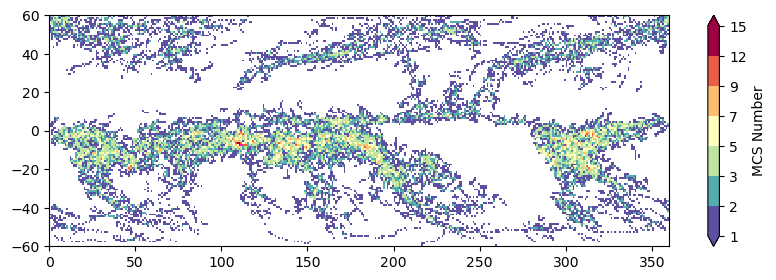

In [21]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, mcs_irnumber_obs, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

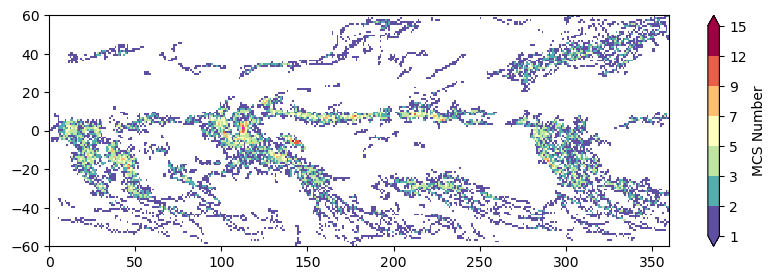

In [22]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [1,2,3,5,7,9,12,15]
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, mcs_irnumber_m1, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

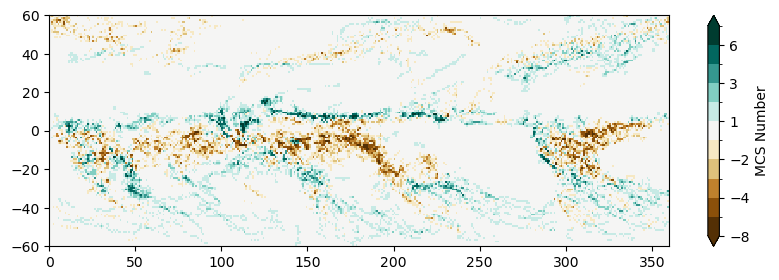

In [23]:
diff = mcs_irnumber_m1 - mcs_irnumber_obs
diffs = gaussian_filter(diff, 1.0)

# Calculate lat/lon bin center value
lonbins = xbins[:-1] + np.diff(xbins)/2.
latbins = ybins[:-1] + np.diff(ybins)/2.

fig = plt.figure(figsize=[10,3], dpi=100)
levels = [-8,-6,-4,-3,-2,-1,1,2,3,4,6,8]
cbticks = levels
cmap = mpl.cm.get_cmap('BrBG')
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
plt.pcolormesh(lonbins, latbins, diff, norm=norm, cmap=cmap)
plt.colorbar(label='MCS Number', extend='both')

In [24]:
# Define boundaries for calculating regional mean
box_mc = [95,150,-20,5]
box_itcz = [151,250,0,12]
box_spcz = [151,210,-30,-1]
box_io = [50,94,-15,5]
box_afc = [10,40,-20,5]
box_amz = [-75%360,-40%360,-20,0]
box_ao = [-40%360,-10%360,-8,8]
box_amz180 = [-75,-40,-20,0]
box_ao180 = [-40,-10,-8,8]
boxes = {
    'MC':box_mc,
    'ITCZ':box_itcz,
    'SPCZ':box_spcz,
    'IO':box_io,
    'AO':box_ao,
    'AFC':box_afc,
    'AMZ':box_amz,
}

## Function to calculate regional mean

In [25]:
def calc_reg_diff(number_mod, number_obs, boxes, latbins, lonbins):
    """
    Calculate regional mean difference in number
    """
    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    # Loop over each region
    for ii, name in enumerate(boxes):
        # print(name)
        xid = np.where((lonbins >= boxes[name][0]) & (lonbins <= boxes[name][1]))[0]
        yid = np.where((latbins >= boxes[name][2]) & (latbins <= boxes[name][3]))[0]
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
        # Calculate mean difference in percentage
        val_mod = number_mod[min(yid):max(yid), min(xid):max(xid)]
        val_obs = number_obs[min(yid):max(yid), min(xid):max(xid)]
        diff_reg[ii] = 100 * (np.nansum(val_mod) - np.nansum(val_obs)) / np.nansum(val_obs)

    # Put values in dictionary
    dict_out = dict(zip(boxes.keys(), diff_reg))
    print(dict_out)
    
    return dict_out

In [26]:
print(model_name[name_map['m1']])
dict_m1 = calc_reg_diff(mcs_irnumber_m1, mcs_irnumber_obs, boxes, latbins, lonbins)

ICON
{'MC': -31.380901668441606, 'ITCZ': 12.275985663082437, 'SPCZ': -86.3672814755413, 'IO': -90.28651292802236, 'AO': -91.35285913528591, 'AFC': -27.437056165267915, 'AMZ': -55.704057279236274}


In [27]:
print(model_name[name_map['m2']])
dict_m2 = calc_reg_diff(mcs_irnumber_m2, mcs_irnumber_obs, boxes, latbins, lonbins)

SCREAM
{'MC': 21.831735889243877, 'ITCZ': -7.347670250896058, 'SPCZ': -54.691259021651966, 'IO': -40.880503144654085, 'AO': -67.22454672245468, 'AFC': -43.70561652679148, 'AMZ': -42.52983293556086}


In [28]:
print(model_name[name_map['m3']])
dict_m3 = calc_reg_diff(mcs_irnumber_m3, mcs_irnumber_obs, boxes, latbins, lonbins)

GEOS
{'MC': 19.204827831025913, 'ITCZ': 5.197132616487456, 'SPCZ': -58.21972734562951, 'IO': -32.98392732354996, 'AO': -41.98047419804742, 'AFC': -12.976113621691415, 'AMZ': -15.322195704057279}


In [29]:
print(model_name[name_map['m4']])
dict_m4 = calc_reg_diff(mcs_irnumber_m4, mcs_irnumber_obs, boxes, latbins, lonbins)

NICAM
{'MC': 16.364927227547035, 'ITCZ': 51.52329749103943, 'SPCZ': -17.441860465116278, 'IO': 15.234102026554856, 'AO': 19.804741980474198, 'AFC': -11.878631375080698, 'AMZ': -25.58472553699284}


In [30]:
print(model_name[name_map['m5']])
dict_m5 = calc_reg_diff(mcs_irnumber_m5, mcs_irnumber_obs, boxes, latbins, lonbins)

X-SHiELD
{'MC': 39.90060347887824, 'ITCZ': 36.02150537634409, 'SPCZ': 10.465116279069768, 'IO': 23.13067784765898, 'AO': -33.19386331938633, 'AFC': -47.385409941898, 'AMZ': -23.914081145584724}


In [31]:
print(model_name[name_map['m6']])
dict_m6 = calc_reg_diff(mcs_irnumber_m6, mcs_irnumber_obs, boxes, latbins, lonbins)

UM
{'MC': 4.543840965566205, 'ITCZ': -35.12544802867384, 'SPCZ': -22.614274258219726, 'IO': -12.43885394828791, 'AO': -64.71408647140865, 'AFC': -43.83473208521627, 'AMZ': -21.288782816229116}


In [32]:
labels = list(dict_m1.keys())
labels

['MC', 'ITCZ', 'SPCZ', 'IO', 'AO', 'AFC', 'AMZ']

## Plot regional mean difference as bar chart

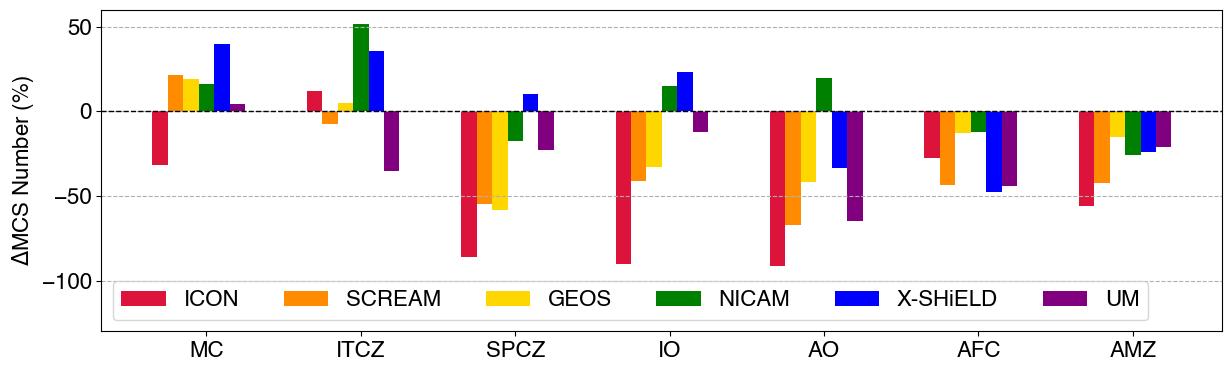

In [33]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.weight'] = 'regular'

labels = list(dict_m1.keys())
x = np.arange(len(labels))
width = 0.1
ylim = (-130,60)

lcolors = {
    'obs':'k', 
    'm1': 'crimson',
    'm2': 'darkorange', 
    'm3': 'gold',
    'm4': 'green',
    'm5': 'blue',
    'm6': 'purple',
}

fig, ax = plt.subplots(figsize=[13,4], dpi=100)
b_m1 = ax.bar(x - 3*width, list(dict_m1.values()), width, color=lcolors['m1'], label=model_name[name_map['m1']])
b_m2 = ax.bar(x - 2*width, list(dict_m2.values()), width, color=lcolors['m2'], label=model_name[name_map['m2']])
b_m3 = ax.bar(x - 1*width, list(dict_m3.values()), width, color=lcolors['m3'], label=model_name[name_map['m3']])
b_m4 = ax.bar(x + 0*width, list(dict_m4.values()), width, color=lcolors['m4'], label=model_name[name_map['m4']])
b_m5 = ax.bar(x + 1*width, list(dict_m5.values()), width, color=lcolors['m5'], label=model_name[name_map['m5']])
b_m6 = ax.bar(x + 2*width, list(dict_m6.values()), width, color=lcolors['m6'], label=model_name[name_map['m6']])
ax.axhline(y=0, lw=1, ls='--', color='k')
ax.grid(which='major', ls='--', axis='y')
ax.set_ylim(ylim[0], ylim[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'$\Delta$MCS Number (%)')
# ax.set_title('', loc='left')
ax.set_xticks(x, labels)
ax.legend(ncol=6)

# ax.bar_label(b_m1, padding=3)
fig.tight_layout()
figname = f'{figdir}globalmap_robust_mcs_number_regional_meandiff_barchart.png'
figname
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [34]:
figname

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures_pf0duration/globalmap_robust_mcs_number_regional_meandiff_barchart.png'